In [4]:
# 1) Build your static product
from custom_importer  import create_product_static_from_dict
from pricers          import create_pricer
from datetime         import date
from dateutil.relativedelta import relativedelta
import numpy as np
    
option_config = {
    "module_name":     "product_definitions",
    "product_type":    "EuropeanOptionStatic",
    "valuation_date":  date.today().isoformat(),
    "expiry_date":     (date.today()+relativedelta(years=1)).isoformat(),
    "strike_price":    150.0,
    "option_type":     "call",
    "currency":        "USD",
    "underlying_symbol": "AAPL"
}
static_opt = create_product_static_from_dict(option_config)

# 2) Build your pricer _instance_
pricer_cfg = {
    "pricer_module_name": "black_scholes_pricer",
    "pricer_class_name":  "BlackScholesPricer",
    "pricer_params": {
    }
}
opt_pricer = create_pricer(static_opt, pricer_cfg)

price0 = opt_pricer.price(160.0, 0.2, risk_free_rate=0.01, dividend_yield=0.02)
print("single‐scenario price:", price0)

#   Or arrays
S_arr   = [150.0,160.0,170.0]
vol_arr = [0.2,0.25,0.3]
print("vectorized prices:", opt_pricer.price(S_arr, vol_arr, risk_free_rate=0.01, dividend_yield=0.02))

single‐scenario price: 16.770896790033362
vectorized prices: [11.04643458 19.70716565 29.20661054]


In [5]:
# 1) Build your static product
bond_config = {
    "module_name":     "product_definitions",
    "product_type":    "QuantLibBondStaticBase",
    "valuation_date":  date.today().isoformat(),
    "maturity_date":   (date.today()+relativedelta(years=5)).isoformat(),
    "face_value":      100.0,
    "coupon_rate":     0.05,
    "currency":        "USD"
}
static_bond = create_product_static_from_dict(bond_config)

# 2) Build your pricer _instance_
pricer_cfg = {
    "pricer_module_name": "quantlib_bond_pricer",
    "pricer_class_name":  "QuantLibBondPricer",
    "pricer_params": {
    }
}
bond_pricer = create_pricer(static_bond, pricer_cfg)

bond_price = bond_pricer.price(market_scenario_data=np.array([.02, 0.025, 0.03, 0.035, 0.04, 0.045]),
                    pillar_times=np.array([0.5, 1.0, 2.0, 3.0, 4.0, 5.0]))

print("Bond static definition:", static_bond.to_dict())
print("Bond price:", bond_price)

Bond static definition: {'product_type': 'VanillaBond', 'valuation_date': '2025-06-08', 'maturity_date': '2030-06-08', 'coupon_rate': 0.05, 'face_value': 100.0, 'freq': 2, 'settlement_days': 0, 'currency': 'USD', 'index_stub': 'GENERIC_IR', 'credit_spread_curve_name': None, 'calendar': 'Federal Reserve Bankwire System', 'day_count': 'Actual/Actual (ISDA)'}
Bond price: [102.42907361]


In [125]:
# 1) Build your static product
conv_config = {
    "module_name":      "product_definitions",
    "product_type":     "ConvertibleBondStaticBase",
    "valuation_date":   date.today().isoformat(),
    "issue_date":       (date.today() - relativedelta(months=6)).isoformat(),
    "maturity_date":    (date.today() + relativedelta(years=5)).isoformat(),
    "coupon_rate":      0.05,
    "conversion_ratio": 1.0,
    "face_value":       100.0,
    "freq":             2,
    "currency":         "USD",
    "underlying_symbol":"DEMO_STOCK"
}
static_conv = create_product_static_from_dict(conv_config)

# 2) Build your pricer instance for convertible‐binomial method
pricer_cfg = {
    "pricer_module_name": "quantlib_bond_pricer",
    "pricer_class_name":  "QuantLibBondPricer",
    "pricer_params": {
        "method":         "convertible_binomial",
        "convertible_engine_steps": 64
    }
}
conv_pricer = create_pricer(static_conv, pricer_cfg)

# 3) Prepare scenario: risk‐free pillars only and static credit for engine
pillar_times = np.array([0.5,1.0,2.0,3.0,4.0,5.0], dtype=float)
rf_curve     = np.array([[0.02,0.025,0.03,0.035,0.04,0.045]])
S0           = np.linspace(50, 150, 32)  # Underlying prices for the convertible bond

result = []
for S in S0:
    price = conv_pricer.price(
        pillar_times=pillar_times,
        market_scenario_data=rf_curve,
        s0_val=S,
        dividend_yield=0.01,
        equity_volatility=0.20,
        credit_spread=0.015
    )
    result.append(price)

print("Convertible static definition:", static_conv.to_dict())
print("Convertible price:", price)

Convertible static definition: {'product_type': 'ConvertibleBond', 'valuation_date': '2025-06-09', 'maturity_date': '2030-06-09', 'coupon_rate': 0.05, 'face_value': 100.0, 'freq': 2, 'settlement_days': 0, 'currency': 'USD', 'index_stub': 'GENERIC_IR', 'credit_spread_curve_name': None, 'calendar': 'Federal Reserve Bankwire System', 'day_count': 'Actual/Actual (ISDA)', 'issue_date': '2024-12-09', 'conversion_ratio': 1.0, 'exercise_type': 'EuropeanAtMaturity', 'underlying_symbol': 'DEMO_STOCK'}
Convertible price: [164.04998447]


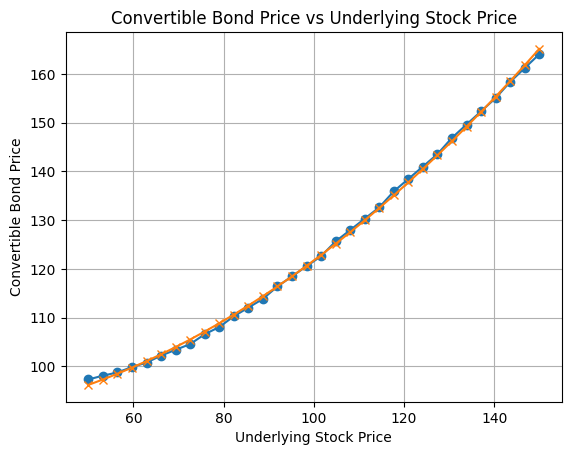

In [126]:
# Do a quadratic fit of the results
from numpy.polynomial import Polynomial
result_flat = np.array(result).flatten()
p = Polynomial.fit(S0, result_flat, 2)
# Evaluate the polynomial fit
result_poly = p(S0)

# Plot stock price vs convertible price vs fitted polynomial
import matplotlib.pyplot as plt
plt.plot(S0, result, marker='o', label='Convertible Bond Price')
plt.plot(S0, result_poly, marker='x', label='Fitted Polynomial')
plt.title("Convertible Bond Price vs Underlying Stock Price")
plt.xlabel("Underlying Stock Price")
plt.ylabel("Convertible Bond Price")
plt.grid()
plt.show()

In [127]:
c_p = conv_pricer.price(
        pillar_times=pillar_times,
        market_scenario_data=rf_curve,
        s0_val=100,
        dividend_yield=0.01,
        equity_volatility=0.20,
        credit_spread=0.015
    )

p(100), c_p


(np.float64(121.72729083821511), array([121.57360162]))